# Successful recall with tau_z
I suspect that this network does not work for values of tau_z that are big (above 50ms). 

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 12)

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect
from plotting_functions import plot_weight_matrix, plot_state_variables_vs_time, plot_winning_pattern
from plotting_functions import plot_network_activity, plot_network_activity_angle
from analysis_functions import calculate_recall_time_quantities, calculate_angle_from_history, get_weights
from connectivity_functions import artificial_connectivity_matrix

## An example

epochs 0
epochs 1
success 0.0


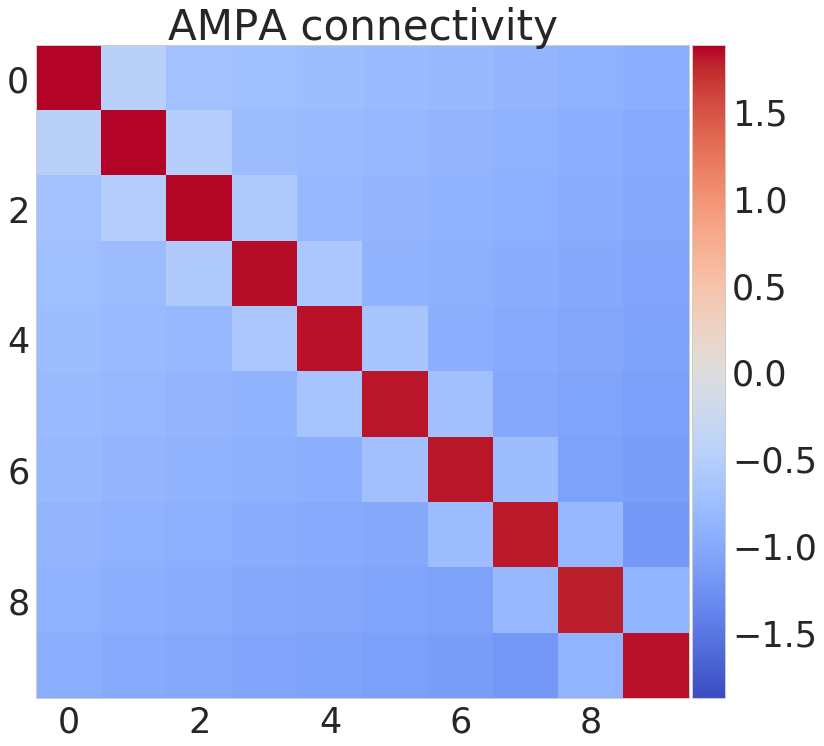

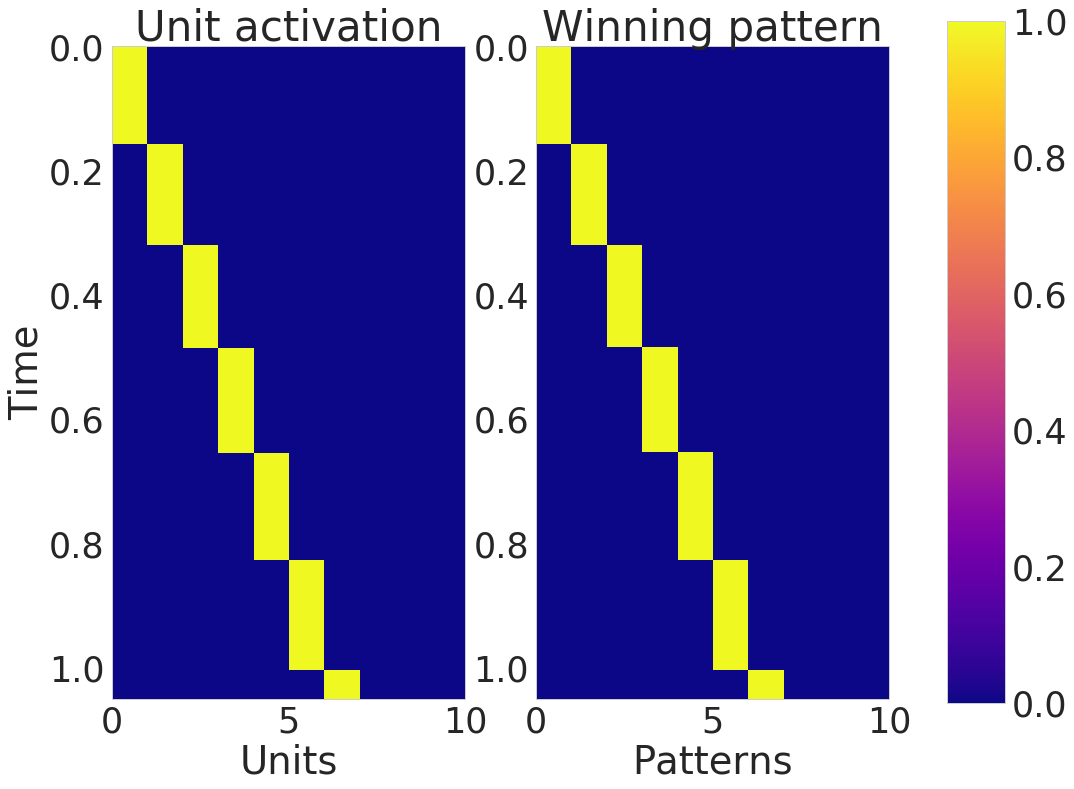

In [31]:
always_learning = True
k_perfect = True

# First we run the training protocol
g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_z_pre_ampa = 0.020
tau_z_post_ampa = tau_z_pre_ampa
tau_p = 10.0

# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o', 's', 'z_pre_ampa', 'w_ampa', 'p_pre']

# Protocol
training_time = 0.500
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 2

# Build the network
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, sigma=sigma, G=G,
                  tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p, z_transfer=False,
                  diagonal_zero=False, strict_maximum=False, perfect=True, k_perfect=k_perfect,
                  always_learning=always_learning)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for training
protocol = Protocol()
patterns_indexes = [i for i in range(n_patterns)]
protocol.simple_protocol(patterns_indexes, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                         inter_sequence_interval=inter_sequence_interval, epochs=epochs)

# Train
epoch_history = manager.run_network_protocol(protocol=protocol, verbose=True)

plot_weight_matrix(manager.nn, ampa=True)

T_recall = 1.0
T_cue = 0.050
nn.strict_maximum = True
sequences = [patterns_indexes]
I_cue = 0.0
n = 1

aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
total_sequence_time, mean, std, success, timings = aux
plot_network_activity_angle(manager)
print('success', success)

## Tau_z with situation

In [11]:
from_pattern = 2
to_pattern = 3
markersize = 32
linewidth = 10

always_learning = True
k_perfect = True

# First we run the training protocol
g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_z_pre_ampa = 0.020
tau_z_post_ampa = tau_z_pre_ampa
tau_p = 10.0

# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o', 's', 'z_pre_ampa', 'w_ampa', 'p_pre']

# Protocol
training_time = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 2

# Recall
T_recall = 1.0
T_cue = 0.100
sequences = [patterns_indexes]
I_cue = 0.0
n = 1

In [22]:
tau_z_vector = np.arange(0.005, 0.155, 0.005)
w_self_vector_tau_z = np.zeros_like(tau_z_vector)
w_next_vector_tau_z = np.zeros_like(tau_z_vector)
w_rest_vector_tau_z = np.zeros_like(tau_z_vector)
success_vector_tau_z = np.zeros_like(tau_z_vector)
persistence_time_vector = np.zeros_like(tau_z_vector)

for index, tau_z_pre_ampa_ in enumerate(tau_z_vector):

    # Build the network
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, 
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa_, tau_z_post_ampa=tau_z_pre_ampa_, tau_p=tau_p,
                z_transfer=False, diagonal_zero=False, strict_maximum=True, perfect=True)


    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    protocol = Protocol()
    patterns_indexes = [i for i in range(n_patterns)]
    protocol.simple_protocol(patterns_indexes, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    epoch_history = manager.run_network_protocol(protocol=protocol, verbose=False)
    
    w_self, w_next, w_rest = get_weights(manager, from_pattern, to_pattern)

    w_self_vector_tau_z[index] = w_self
    w_next_vector_tau_z[index] = w_next
    w_rest_vector_tau_z[index] = w_rest
    
    nn.strict_maximum = True
    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    
    success_vector_tau_z[index] = success
    persistence_time_vector[index] = mean

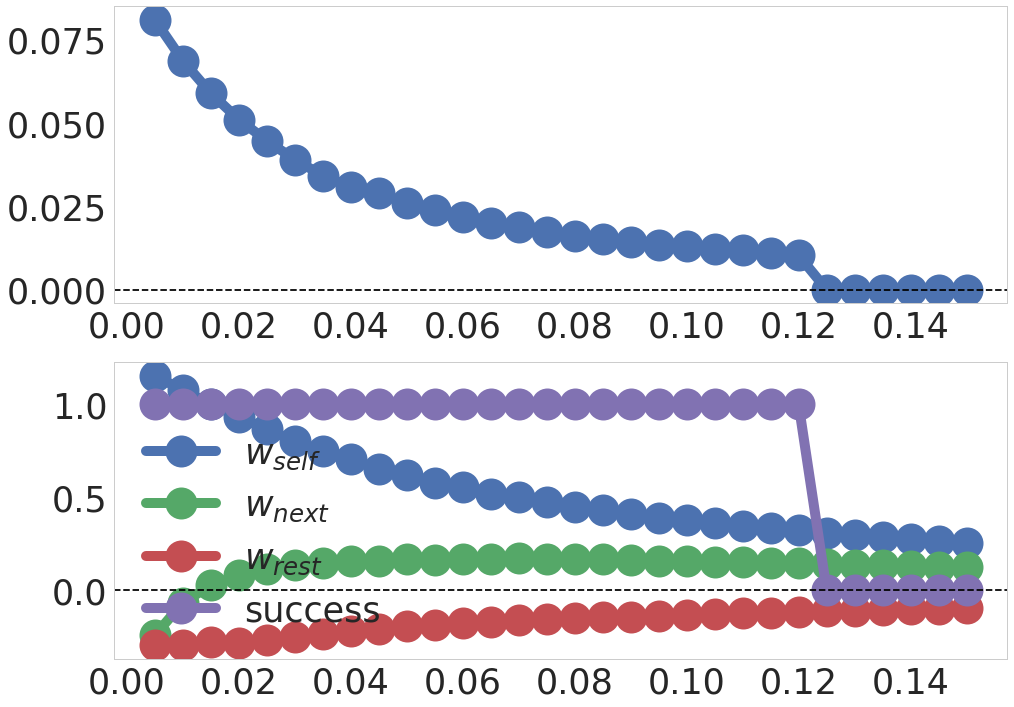

In [23]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(tau_z_vector, persistence_time_vector,'o-', lw=linewidth, markersize=markersize)
ax1.axhline(0, ls='--', color='black')


ax2.plot(tau_z_vector, w_self_vector_tau_z, 'o-', lw=linewidth, markersize=markersize, label=r'$w_{self}$')
ax2.plot(tau_z_vector, w_next_vector_tau_z, 'o-', lw=linewidth, markersize=markersize, label=r'$w_{next}$')
ax2.plot(tau_z_vector, w_rest_vector_tau_z, 'o-', lw=linewidth, markersize=markersize, label=r'$w_{rest}$')

ax2.plot(tau_z_vector, success_vector_tau_z/100.0, 'o-', lw=linewidth, markersize=markersize, label='success')
ax2.axhline(0, ls='--', color='black')

ax2.legend();

## tau_p

In [27]:
tau_p_vector = np.arange(1.0, 23.0, 2.0)
w_self_vector_tau_p = np.zeros_like(tau_p_vector)
w_next_vector_tau_p = np.zeros_like(tau_p_vector)
w_rest_vector_tau_p = np.zeros_like(tau_p_vector)
success_vector_tau_p = np.zeros_like(tau_p_vector)
persistence_time_vector = np.zeros_like(tau_p_vector)

for index, tau_p_ in enumerate(tau_p_vector):

    # Build the network
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, 
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_pre_ampa, tau_p=tau_p_,
                z_transfer=False, diagonal_zero=False, strict_maximum=True, perfect=True)


    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    protocol = Protocol()
    patterns_indexes = [i for i in range(n_patterns)]
    protocol.simple_protocol(patterns_indexes, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    epoch_history = manager.run_network_protocol(protocol=protocol, verbose=False)
    
    w_self, w_next, w_rest = get_weights(manager, from_pattern, to_pattern)

    w_self_vector_tau_p[index] = w_self
    w_next_vector_tau_p[index] = w_next
    w_rest_vector_tau_p[index] = w_rest
    
    nn.strict_maximum = True
    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    
    success_vector_tau_p[index] = success
    persistence_time_vector[index] = mean

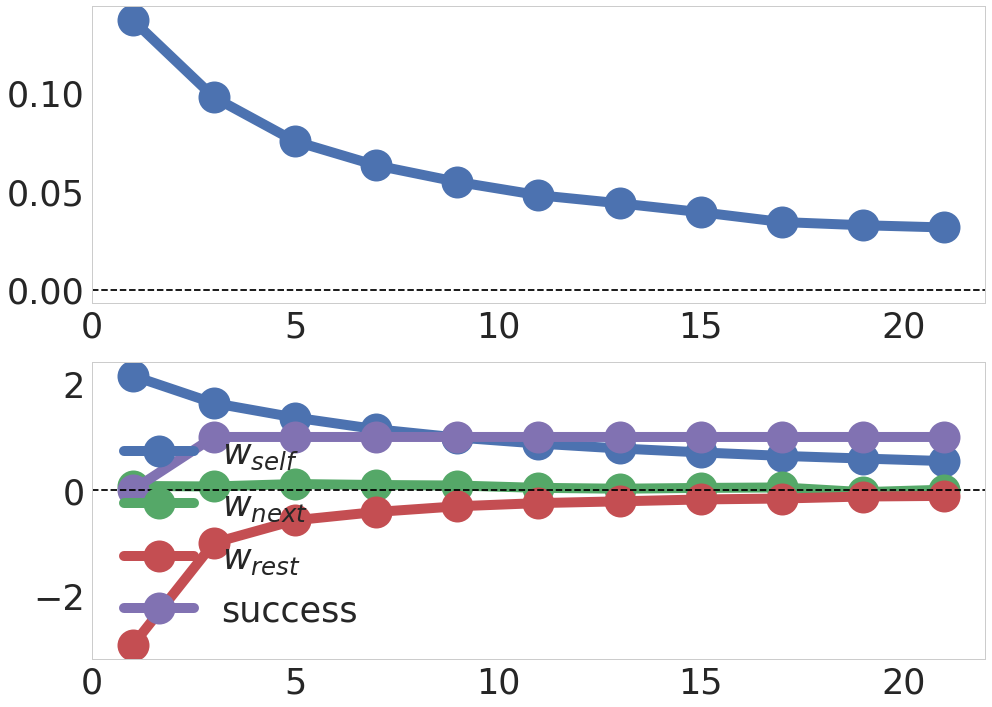

In [28]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(tau_p_vector, persistence_time_vector,'o-', lw=linewidth, markersize=markersize)
ax1.axhline(0, ls='--', color='black')


ax2.plot(tau_p_vector, w_self_vector_tau_p, 'o-', lw=linewidth, markersize=markersize, label=r'$w_{self}$')
ax2.plot(tau_p_vector, w_next_vector_tau_p, 'o-', lw=linewidth, markersize=markersize, label=r'$w_{next}$')
ax2.plot(tau_p_vector, w_rest_vector_tau_p, 'o-', lw=linewidth, markersize=markersize, label=r'$w_{rest}$')

ax2.plot(tau_p_vector, success_vector_tau_p/100.0, 'o-', lw=linewidth, markersize=markersize, label='success')
ax2.axhline(0, ls='--', color='black')

ax2.legend();